<br>
<font size=30px><center><strong>Key learnings</center></font>
<br><br>
This notebooks aims to regroup all the key learnings found during the project from EDA to deep dives on the predictions.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-data-loading" data-toc-modified-id="Imports-and-data-loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and data loading</a></span></li><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory data analysis</a></span><ul class="toc-item"><li><span><a href="#Is-there-a-lot-of-sentences-that-overlap-2-different-discourses-?" data-toc-modified-id="Is-there-a-lot-of-sentences-that-overlap-2-different-discourses-?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Is there a lot of sentences that overlap 2 different discourses ?</a></span></li><li><span><a href="#Distribution-length-of-discourses" data-toc-modified-id="Distribution-length-of-discourses-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Distribution length of discourses</a></span><ul class="toc-item"><li><span><a href="#Length-distribution-across-discourse-types" data-toc-modified-id="Length-distribution-across-discourse-types-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Length distribution across discourse types</a></span></li></ul></li><li><span><a href="#Distribution-length-of-essays" data-toc-modified-id="Distribution-length-of-essays-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Distribution length of essays</a></span></li><li><span><a href="#Distribution-of-discourse-types" data-toc-modified-id="Distribution-of-discourse-types-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Distribution of discourse types</a></span><ul class="toc-item"><li><span><a href="#Distribution-discourse-types-across-essays-on-average" data-toc-modified-id="Distribution-discourse-types-across-essays-on-average-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Distribution discourse types across essays on average</a></span></li></ul></li></ul></li><li><span><a href="#First-iteration-on-predictions" data-toc-modified-id="First-iteration-on-predictions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>First iteration on predictions</a></span><ul class="toc-item"><li><span><a href="#Load-data-from-dataset" data-toc-modified-id="Load-data-from-dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load data from dataset</a></span></li><li><span><a href="#Get-preds" data-toc-modified-id="Get-preds-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Get preds</a></span></li><li><span><a href="#Compare-lengths-per-class" data-toc-modified-id="Compare-lengths-per-class-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Compare lengths per class</a></span></li><li><span><a href="#Compare-distribution-of-lengths-per-class" data-toc-modified-id="Compare-distribution-of-lengths-per-class-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Compare distribution of lengths per class</a></span></li><li><span><a href="#Number-of-discourses-under-a-certain-length" data-toc-modified-id="Number-of-discourses-under-a-certain-length-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Number of discourses under a certain length</a></span></li><li><span><a href="#Stammering-issue" data-toc-modified-id="Stammering-issue-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Stammering issue</a></span><ul class="toc-item"><li><span><a href="#Visual-comparison" data-toc-modified-id="Visual-comparison-3.6.1"><span class="toc-item-num">3.6.1&nbsp;&nbsp;</span>Visual comparison</a></span><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3.6.1.1"><span class="toc-item-num">3.6.1.1&nbsp;&nbsp;</span>Data preparation</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Sentences-approach-exploration" data-toc-modified-id="Sentences-approach-exploration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sentences approach exploration</a></span></li></ul></div>

# Imports and data loading

In [46]:
# imports
%load_ext autoreload
%autoreload 2 

import pickle
import os
import random
from tqdm.notebook import tqdm

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from IPython.display import HTML 
from termcolor import colored

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# utils var
sns.set_style('whitegrid')

In [3]:
# data loading
df = pd.read_csv('../raw_data/train.csv')


In [4]:
#Max len of essay 
SEQ_LEN = 1024 ## THIS SHOULD NOT BE CHANGED without appropriate changes in the preprocessing 

#Train, val, test split proportion
VAL_SPLIT = 0.8
TEST_SPLIT = 0.9

#only to get length at this stage
df_essays = pd.read_csv('../raw_data/preprocessed_v3.csv')
LEN=len(df_essays)
del df_essays

idx_val=int(LEN*VAL_SPLIT)
idx_test=int(LEN*TEST_SPLIT)

idx_train=list(range(0,idx_val))
idx_val=list(range(idx_val,idx_test))
idx_test=list(range(idx_test,LEN))

assert(len(idx_test)+len(idx_train)+len(idx_val)==LEN)

In [5]:
#labels map
labels_mapping = {'B-Lead' : 0,
                  'B-Position' : 1,
                  'B-Evidence' : 2,
                  'B-Claim' : 3,
                  'B-Concluding_Statement' : 4,
                  'B-Counterclaim' : 5,
                  'B-Rebuttal' : 6,
                  'I-Lead' : 7,
                  'I-Position' : 8,
                  'I-Evidence' : 9,
                  'I-Claim' : 10,
                  'I-Concluding_Statement' : 11,
                  'I-Counterclaim' : 12,
                  'I-Rebuttal': 13,
                 'O':14,
                 'PAD':15}

reversed_mapping = {v:(k[2:] if v<14 else k) for k,v in labels_mapping.items()}

# Exploratory data analysis

## Is there a lot of sentences that overlap 2 different discourses ? 

In [6]:
# Check whether there is a lot of type change in the middle of a sentence
count=0
for i in range(len(df)-1):
    if '.' in df.loc[i,'discourse_text'][-3:]:
        count+=1        
        
print(f'Proportion of sentences overlapping 2 different discourses : {(1-count/len(df))*100:.2f}%')

Proportion of sentences overlapping 2 different discourses : 33.05%


## Distribution length of discourses

In [7]:
#create discourse_len feature
df['discourse_w_len']=df['discourse_text'].apply(lambda txt : len(txt.split()))
df['discourse_c_len']=df['discourse_text'].apply(len)

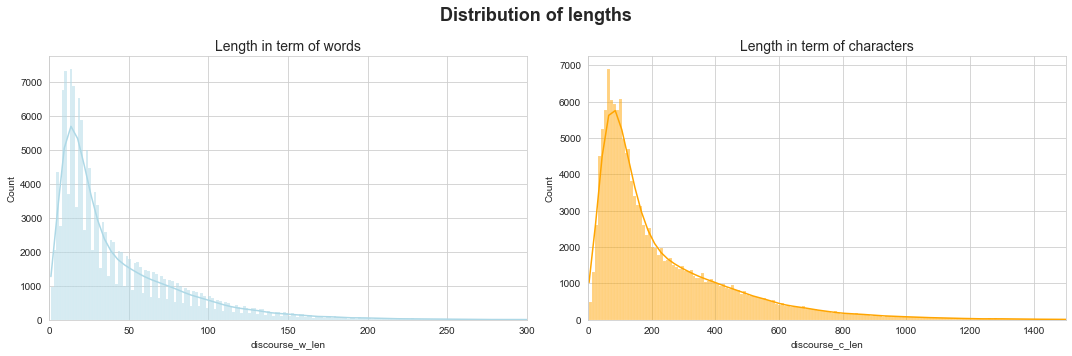

In [8]:
# plotting lenght both in term of words and characters

fig, axs = plt.subplots(1,2,figsize=(15,5),tight_layout=True)

sns.histplot(x=df['discourse_w_len'],kde=True,ax=axs[0],color='lightblue')
sns.histplot(x=df['discourse_c_len'],kde=True,ax=axs[1],color='orange')

axs[0].set_title('Length in term of words',size=14)
axs[1].set_title('Length in term of characters',size=14)

axs[0].set_xlim((0,300))
axs[1].set_xlim((0,1500))

plt.suptitle('Distribution of lengths',size=18,weight='bold');

### Length distribution across discourse types

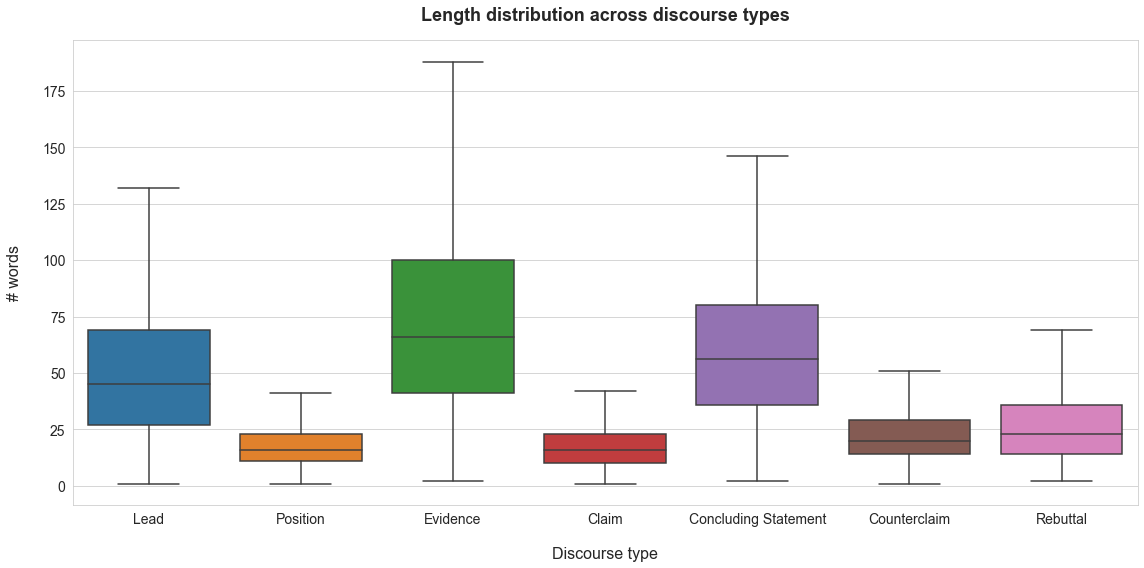

In [9]:
plt.figure(figsize=(16,8),tight_layout=True)
sns.boxplot(y=df['discourse_w_len'],x=df['discourse_type'],showfliers=False)

plt.xlabel('Discourse type',size=16,labelpad=20)
plt.ylabel('# words',size=16,labelpad=20)

plt.xticks(size=14)
plt.yticks(size=14)

plt.title('Length distribution across discourse types',size=18,pad=20,weight='bold');



## Distribution length of essays

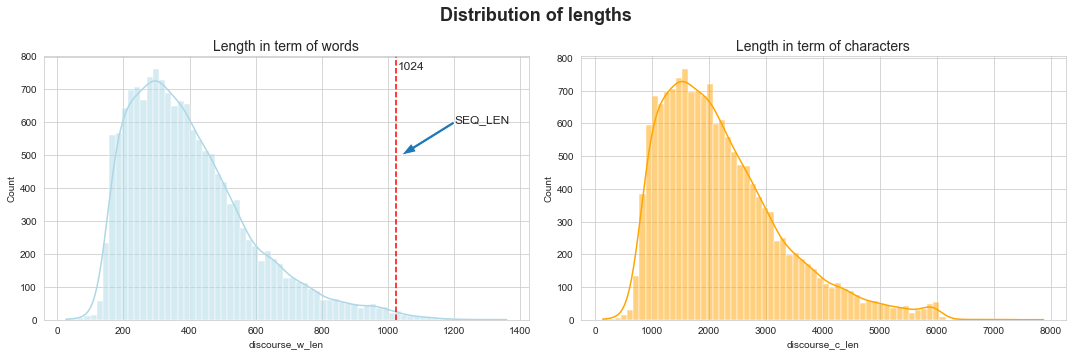

In [10]:
## agg by essay id
df_essays = df.groupby('id').agg({'discourse_c_len':sum,'discourse_w_len':sum})

#plot
fig, axs = plt.subplots(1,2,figsize=(15,5),tight_layout=True)

sns.histplot(x=df_essays['discourse_w_len'],kde=True,ax=axs[0],color='lightblue')
sns.histplot(x=df_essays['discourse_c_len'],kde=True,ax=axs[1],color='orange')

axs[0].set_title('Length in term of words',size=14)
axs[1].set_title('Length in term of characters',size=14)

#sns.lineplot(x=[1024,1024],y=[1,740],color='r',ax=axs[0])
axs[0].axvline(1024,ls='--',lw=1.5,color='r')
axs[0].arrow(x=1200,y=600,dx=-160,dy=-100,width=10,length_includes_head=True,)
axs[0].annotate('SEQ_LEN',(1200,600),size=12)
axs[0].annotate('1024',(1030,760),size=12)

plt.suptitle('Distribution of lengths',size=18, weight='bold');

## Distribution of discourse types

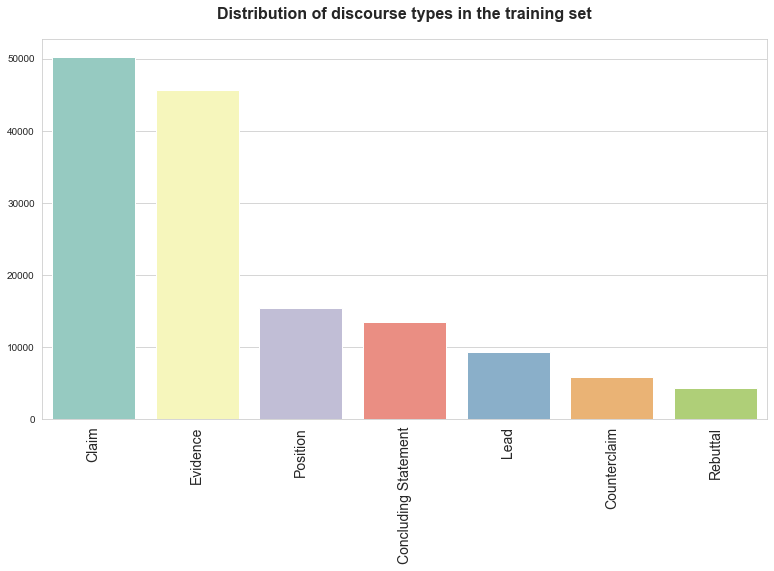

In [11]:
plt.figure(figsize=(13,7))

sns.countplot(x=df['discourse_type'],palette='Set3',
              order=df['discourse_type'].value_counts().index);

plt.xticks(rotation=90,size=14,);
plt.xlabel(None)
plt.ylabel(None)

plt.title('Distribution of discourse types in the training set',size=16,pad=20,weight='bold');

<font size="4"> __Learning__ </font> 
<br><br>
<font size="3">The classes are __imbalanced__. Plan of action :
    <ol>
        <li>Evaluate impact of training an imbalanced dataset on the result. One hypothesis is that it might not have a negative impact as essays naturally have classes longer than some others</li>
        <li>Create a balanced dataset and iterate. A way to do so would be to create length per discourse for each essay, get the std and train on the essays with this lower std.</li>
    
</font>

### Distribution discourse types across essays on average

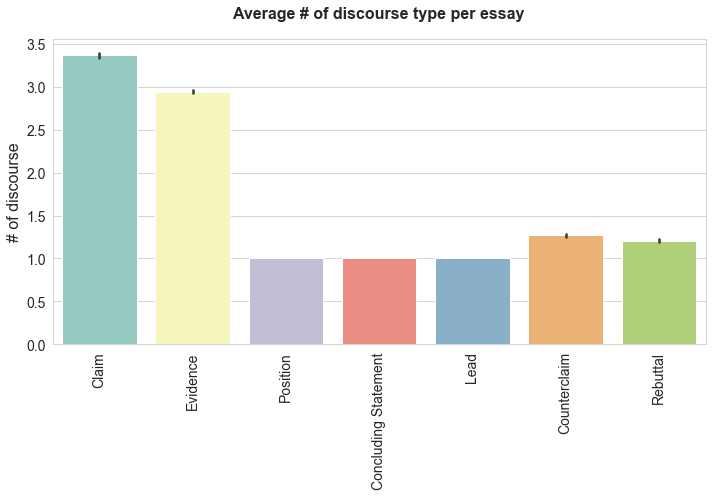

In [12]:
#agg
df_dist = df.groupby(['id','discourse_type']).agg({'discourse_text':'count'}).reset_index()

#plot
plt.figure(figsize=(10,7),tight_layout=True)
sns.barplot(x='discourse_type',y='discourse_text',
            data=df_dist,estimator=np.mean,palette='Set3',
            order=df['discourse_type'].value_counts().index)

plt.xticks(rotation=90,size=14);
plt.yticks(size=14)
plt.xlabel(None)
plt.ylabel('# of discourse',size=16);

plt.title('Average # of discourse type per essay',size=16,weight='bold',pad=20);

# First iteration on predictions

These learnings are derived from model_v3 ; analysis on the test split 

__Key take away__

- Length of each class is not fully captured by the model when looking at average length
- This is most likely driven by discourses predicted to be of very small length, kind of stammering from the model 
    - could we set threshold per class to avoid this ?

## Load data from dataset 

Let's also take the original train.csv file instead of our re-processed dataset for comparison. We will use it for **high level** comparisons. 

In [13]:
# load data from pickles and csv files
with open('../raw_data/dataset_v3.pickle','rb') as file:
    dataset = pickle.load(file)
    
with open('../raw_data/preds_on_testsplit.pickle','rb') as file:
    y_pred_proba = pickle.load(file)

    
df_essays = pd.read_csv('../raw_data/preprocessed_v3.csv',converters={'predictionstring':eval,
                                                                     'label':eval})

df_raw = pd.read_csv('../raw_data/train.csv')

In [14]:
# get X_test,y_test
X_test = {
    'input_ids' : dataset['inputs']['input_ids'][idx_test],
    'attention_mask' : dataset['inputs']['attention_mask'][idx_test]
}

y_test = dataset['labels'][idx_test]
ps_test = dataset['predictionstrings'][idx_test]

## Get preds

In [15]:
def get_preds(y_pred,ps):
    """
    Generate readable predictions from the output of the model.

    Args:
        y_pred (ndarray): output of the model
        ps (ndarray): predictionstring referring to the token predicted

    Returns:
        DataFrame : DataFrame with class and predictionstrings
    """


    labels = []
    predictionstrings = []
    counts = []
    
    counter=dict()
    
    for tok,pos in zip(y_pred,ps):
        
        if tok <= 13:
            lab = reversed_mapping[tok]
            labels.append(lab)
            predictionstrings.append(pos)
            if len(labels)<2:
                counts.append(str(1))
                counter.setdefault(lab,1)
                continue
            if lab == labels[-2]:
                counts.append(str(counter[lab]))
            else: 
                try:
                    counter[lab]+=1
                except KeyError:
                    counter.setdefault(lab,1)
                counts.append(str(counter[lab]))
    
    preds = pd.DataFrame([labels,counts,predictionstrings],index=['class','count','predictionstring']).T
    preds['class'] += ' ' + preds['count'].astype(str)
    preds = preds.groupby('class',sort=False).agg({'predictionstring':list}).reset_index()
    preds['class']=preds['class'].apply(lambda txt : txt.split()[0])
    preds['predictionstring']=preds['predictionstring'].apply(lambda l_ : [str(l) for l in l_])
    preds['predictionstring']=preds['predictionstring'].apply(lambda l_ : ' '.join(l_))
    
    return preds

In [16]:
##creating pred_df
y_pred = np.argmax(y_pred_proba,axis=-1)
pred_df=pd.DataFrame()
for i,idx in tqdm(enumerate(idx_test),total=len(idx_test)):
    
    pred_ = get_preds(y_pred[i],ps_test[i])
    
    pred_['id']=df_essays.iloc[idx]['id']
    
    pred_df = pred_df.append(pred_)

  0%|          | 0/1560 [00:00<?, ?it/s]

In [17]:
# let's check
pred_df.head()

,class,predictionstring,id
0,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,E6870101D8EE
1,Evidence,31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 4...,E6870101D8EE
2,Lead,65 66 67 68 69 70 71 72 73 74 75 76 77 78,E6870101D8EE
3,Claim,79 80 81 82,E6870101D8EE
4,Lead,83 84,E6870101D8EE


In [18]:
#create list of ids in the test split for later use
ids_test_split = pred_df.id.unique()

## Compare lengths per class 

In [19]:
#compute lengths
df_raw['discourse_length'] = df_raw['predictionstring'].apply(lambda txt : len(txt.split()))
pred_df['discourse_length'] = pred_df['predictionstring'].apply(lambda txt : len(txt.split()))

#create df 
a = df_raw.groupby('discourse_type').agg({'discourse_length':'mean'}).reset_index() #take mean of length
a['class'] = a['discourse_type'].replace('Concluding Statement','Concluding_Statement')
a.drop('discourse_type',axis=1,inplace=True)

b = pred_df.groupby('class').agg({'discourse_length':'mean'}).reset_index() #take mean of length

comparison_length = a.merge(b,on='class',suffixes=('_true','_pred')) 

#house cleaning for plotting purposes
comparison_length.rename({'discourse_length_pred':'prediction','discourse_length_true':'ground_truth'},
                         inplace=True, axis=1)
comparison_length.set_index("class",inplace=True)
comparison_length = comparison_length.unstack().reset_index()
comparison_length.rename({'level_0':'type',0:'value'},axis=1,inplace=True)
comparison_length.sort_values('value',inplace=True,ascending=False)

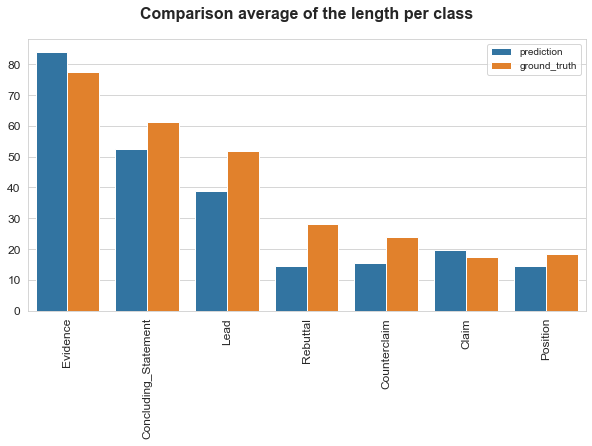

In [20]:
#plot
plt.figure(figsize=(10,5))

sns.barplot(data=comparison_length, y='value', x='class',hue='type')

#pretty plot
plt.xticks(rotation=90,size=12);
plt.yticks(size=12)

plt.xlabel(None)
plt.ylabel(None)

plt.title('Comparison average of the length per class',size=16,weight='bold',pad=20)
plt.legend();

## Compare distribution of lengths per class

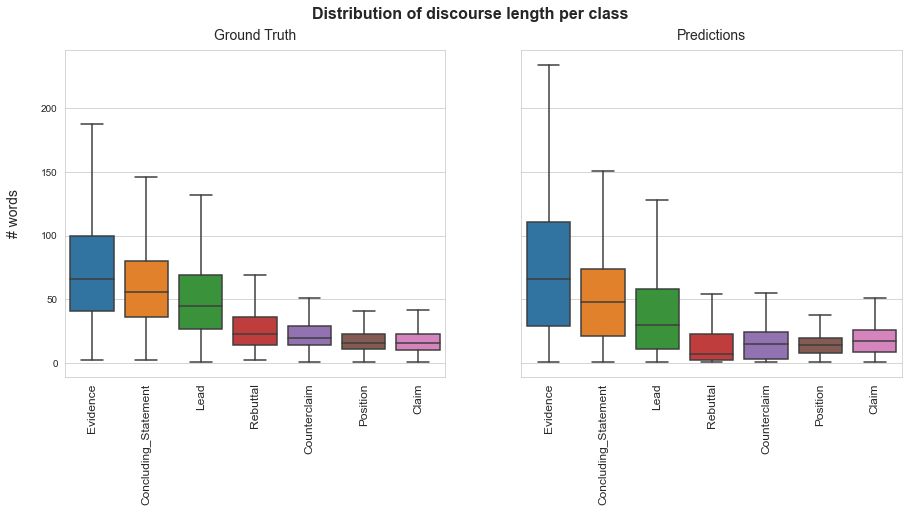

In [21]:
#df, replace, order
a = df_raw.sort_values('discourse_length',ascending=False)
b = pred_df.sort_values('discourse_length',ascending=False)

a.replace('Concluding Statement','Concluding_Statement',inplace=True)

order = a.groupby('discourse_type',sort=False).mean()\
            .sort_values('discourse_length',ascending=False).index


#plot
fig,axs = plt.subplots(1,2,figsize=(15,6), sharey= True)

sns.boxplot(data = a,x='discourse_type',y='discourse_length',ax=axs[0],showfliers=False,order=order)
sns.boxplot(data = b,x='class',y='discourse_length',ax=axs[1],showfliers=False,order=order)

#pretty plot
axs[0].set_xticklabels(labels = order, rotation=90,size=12)
axs[1].set_xticklabels(labels = order, rotation=90,size=12)

axs[0].set_xlabel(None)
axs[0].set_ylabel('# words',size=14,labelpad=20)
axs[1].set_xlabel(None)
axs[1].set_ylabel(None)

axs[0].set_title('Ground Truth',size=14,pad=10)
axs[1].set_title('Predictions',size=14,pad=10);

plt.suptitle('Distribution of discourse length per class',size=16,weight='bold');

## Number of discourses under a certain length

In [22]:
def show_values_on_bars(axs,counts):
    """
    This function adds value on top of bar. Should be customed for each use case.
    """
    def _show_on_single_plot(ax,counts):
        for p,v in zip(ax.patches,counts):
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 1
            value = f'{p.get_height()/v*100:.1f}%'
            ax.text(_x, _y+1.5, value, ha="center",size=12)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax,counts)
    else:
        _show_on_single_plot(axs,counts)

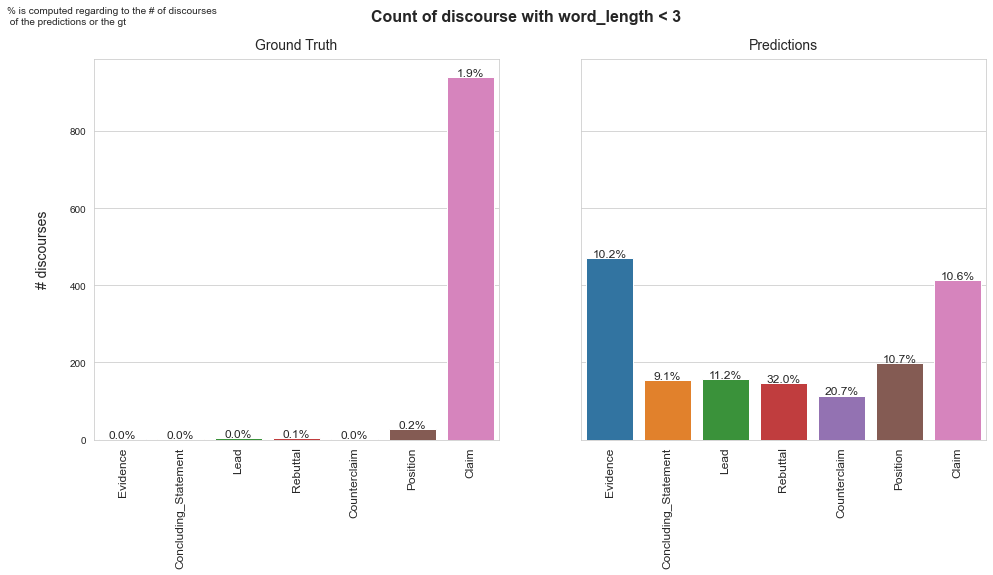

In [23]:
## define the threshold 
LIMIT = 3

#df, order, replace
a = df_raw.sort_values('discourse_type')
b = pred_df.sort_values('class')

a.replace('Concluding Statement','Concluding_Statement',inplace=True)


order = a.groupby('discourse_type',sort=False).mean()\
            .sort_values('discourse_length',ascending=False).index

## computing total count per class to get %
v_a=a.groupby('discourse_type').count().loc[order]['id']
v_b=b.groupby('class').count().loc[order]['id']

##filtering according to limot
a = a[a['discourse_length']<LIMIT]
b = b[b['discourse_length']<LIMIT]

#plot
fig,axs = plt.subplots(1,2,figsize=(16,7),tight_layout=False,sharey=True)

sns.countplot(data = a,x='discourse_type',ax=axs[0],order=order)
sns.countplot(data = b,x='class',ax=axs[1],order=order)

#pretty plot
axs[0].set_xticklabels(labels = order, rotation=90,size=12)
axs[1].set_xticklabels(labels = order, rotation=90,size=12)

axs[0].set_xlabel(None)
axs[0].set_ylabel('# discourses',size=14,labelpad=20)
axs[1].set_xlabel(None)
axs[1].set_ylabel(None)

show_values_on_bars(axs[0],v_a)
show_values_on_bars(axs[1],v_b)

axs[0].set_title('Ground Truth',size=14,pad=10)
axs[1].set_title('Predictions',size=14,pad=10);

fig.text(.05,.95,'% is computed regarding to the # of discourses \n of the predictions or the gt')
plt.suptitle(f'Count of discourse with word_length < {LIMIT}',size=16,weight='bold');



In [24]:
## TODO : identify patterns ; maybe there are some proba thresholds that could be set up (idea is that sometimes the model 'hesitate' between two classes thus they both have high probability in the output; could be cleared setting up a minimal probability for a token to be classified)

## Stammering issue

### Visual comparison

In [25]:
from feedback_prize import utils

In [26]:
utils.css()

#### Data preparation

In [65]:
# flag essay with a length issue
pred_df['flag'] = np.where(pred_df['discourse_length']<3,1,0)
# list essays with > 3 stammers for exploration purporses
stammerers = pred_df.groupby('id').sum()
stammerers = stammerers[stammerers['flag']>3].index

stam_df = pred_df[pred_df['id'].isin(stammerers)].copy()
stam_df.head(3)

,class,predictionstring,id,discourse_length,flag
0,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,E6C2FD3578B3,119,0
1,Position,119 120 121 122 123 124 125 126 127 128 129 13...,E6C2FD3578B3,28,0
2,Claim,147,E6C2FD3578B3,1,1


In [66]:
#link with the essays
stam_df['text'] = stam_df['id'].apply(utils.get_essay)

In [67]:
# connect the predictions to text
slicer_vect = np.vectorize(utils.slicering)
stam_df['discourse_text'] = slicer_vect(stam_df['predictionstring'],stam_df['text'])

#transform into html string for later visualization
stam_df['html'] = stam_df.apply(utils.render_html,axis=1)
stam_df = stam_df.groupby('id').agg({'html':' '.join,'flag':sum})
#display(stam_df.head(3))

#same for truth df
df_true = df_raw[df_raw['id'].isin(stammerers)].copy() #selecting only essays of interest
df_true['discourse_type'].replace('Concluding Statement','Concluding_Statement',inplace=True)
df_true['html'] = df_true.apply(utils.render_html,axis=1)
df_true = df_true.groupby('id').agg({'html':' '.join})
#display(df_true.head(3))


In [92]:
## showing a comparison choosing a random essay 
random_idx = random.choice(stam_df.index)
utils.comparison_text(stam_df.loc[random_idx,'html'],df_true.loc[random_idx,'html'])

##NB : difference comes from my shitty model which apparently tends to classify a lot of tokens as O -__-

# Sentences approach exploration 